# Compare K-Means Seeding Against Choosing N Points at Random

K-means++ maximises the spread between N centroids, and does so according to a weight function.
ADD IMAGE HERE

Things to Plot:

* Should kmeans convergence. Does it converge faster
* Should kmeans energy w.r.t. reference ACE and other method
* Plot the timings
* See if I can reduce the number of points by (..)

In [1]:
""" Parser function definitions
"""
import numpy as np
from pathlib import Path
import re
from typing import List

from isdfbenchmarks.parser import static
from isdfbenchmarks.parser.stdout import parse_exchange_energy


def parse_kmeans_iterations(path) -> List[int]:
    pat = re.compile(r'^Kmeans converged in\s+(\d+)\s+iterations\b',
                     re.IGNORECASE | re.MULTILINE)
    
    with open(path, "r", encoding="utf-8") as fid:
        text = fid.read()
    
    # All iteration counts as ints
    return np.array([int(n) for n in pat.findall(text)])


def parse_kmeans_set(root, directories) -> dict:
    iters = {}
    for dir in directories:
        iters[dir] = parse_kmeans_iterations(root / dir / "terminal.out")
    return iters


def parse_exx(root, directories) -> dict:
    """ Parse the final exact exchange energy from a calculation
    :param root: 
    :param directories: 
    :return: 
    """
    exx = {}
    for dir in directories:
        exx[dir] = static.info_file(root / dir)['Energy']['Exchange']
    return exx


def parse_exx_convergence(root: Path, directories: list) -> dict:
    exx_convergence = {}
    for dir in directories:
        with open(root / dir / "terminal.out", "r", encoding="utf-8") as fid:
            text = fid.read()
        exx_convergence[dir] = np.array([e for e in parse_exchange_energy(text).values()])
    return exx_convergence

In [2]:
""" Define the root directories for each set of calculations, and the data set
"""
root_ace_ref = Path("/home/bucchera/exchange_calcs/ace_references")
root_kmeans_l2 = Path("/home/bucchera/exchange_calcs/kmeans_l2")
root_kmeanspp_l2 = Path("/home/bucchera/exchange_calcs/kmeans_plus_plus")
root_omp_kmeanspp_l2 = Path("/home/bucchera/exchange_calcs/omp_kmeans_plus_plus")



## Number of K-Means per SCF step 
 
* Fisher-Yates vs K-means++

In [3]:
""" Parse data
"""
molecules =  ["anthracene", "tetracene", "pentacene", "ether_crown"]
fy_iters = parse_kmeans_set(root_kmeans_l2, molecules)
kmeanspp_iters = parse_kmeans_set(root_kmeanspp_l2, molecules)

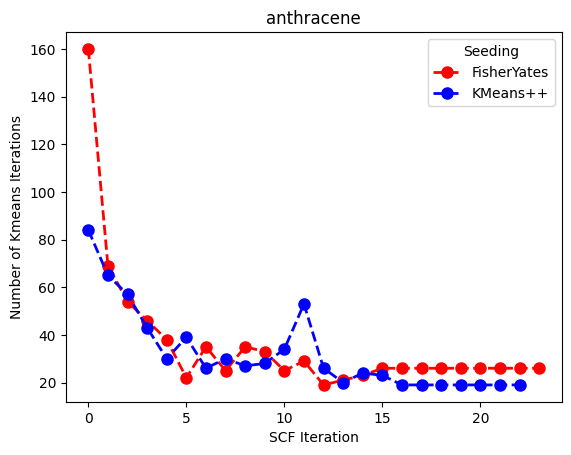

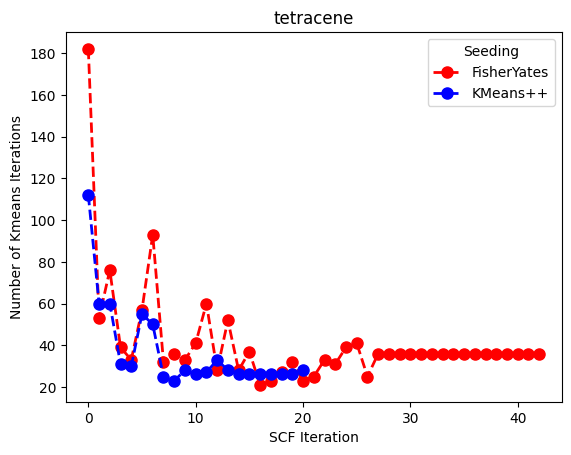

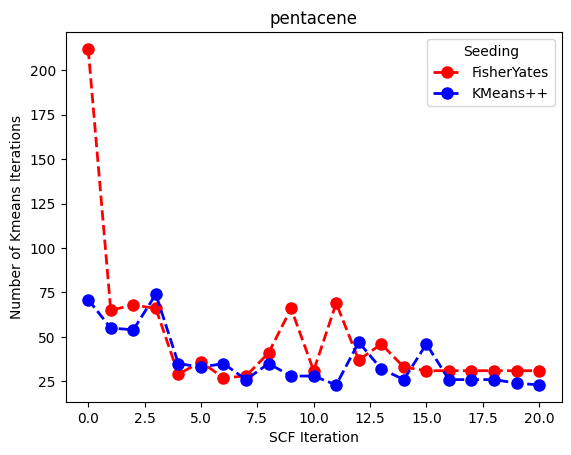

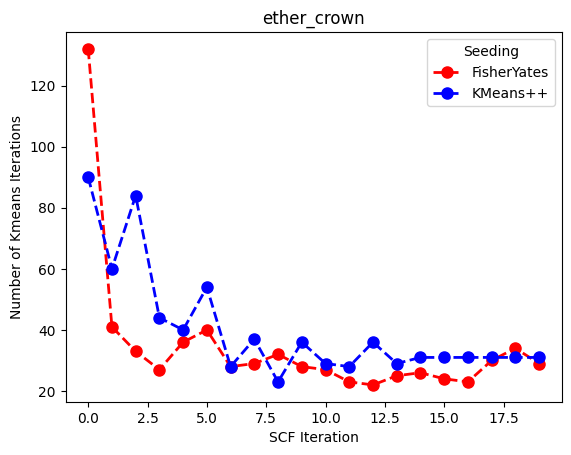

In [4]:
"""Number of K-Means per SCF step vs ACE reference and Fisher-Yates
"""
import matplotlib.pyplot as plt


for molecule in molecules:
    plt.plot(np.arange(len(fy_iters[molecule]), dtype=int), fy_iters[molecule], 'ro--', linewidth=2, markersize=8, label='FisherYates')
    plt.plot(np.arange(len(kmeanspp_iters[molecule]), dtype=int), kmeanspp_iters[molecule], 'bo--', linewidth=2, markersize=8, label='KMeans++')
    plt.xlabel("SCF Iteration")
    plt.ylabel("Number of Kmeans Iterations")
    plt.title(molecule)
    plt.legend(title='Seeding')
    plt.show()
    

In all systems, using k-means++ over (unweighted) random draw of grid points via Fisher Yates, results in far fewer subsequent k-means iterations. Although this trend does not necessarily apply to all SCF steps. One wonders:

### Questions Answered

* Does this result in overall fewer k-means iterations?
    * 3/4 yes. For the ether crown no  

* Does the extra time spent doing k-means++ make up for the savings? 
    * No. On the whole, the current k-means++ algorithm is horrifically slow because it has no OMP dressings over the grid. Currently it takes longer than weighted k-means iterations summed over ALL SCF steps, which is madness.

### Questions to Answer

* If I randomise the seed, run M different seeds in parallel and choose the best, how does it perform?

* Does this require fewer points to achieve the same precision in exact exchange energy?

* Does this work in conjunction with one/both of the convergence criteria I've tested previously, to give an overall better result?

In [5]:
# Total number of k-means iterations in a calculation

molecules =  ["anthracene", "tetracene", "pentacene", "ether_crown"]

print("Molecule |  Fisher-Yates |  K-means++  | Total K-means Itr Change(%)")
print("--------------------------------------------------------------------")
for molecule in molecules:
    nitr_fy = np.sum(fy_iters[molecule])
    nitr_kpp = np.sum(kmeanspp_iters[molecule])
    change = float(nitr_kpp) / float(nitr_fy)
    print(f"{molecule} |   {nitr_fy}      |   {nitr_kpp}   | {change * 100}")

# 

Molecule |  Fisher-Yates |  K-means++  | Total K-means Itr Change(%)
--------------------------------------------------------------------
anthracene |   868      |   742   | 85.48387096774194
tetracene |   1776      |   772   | 43.468468468468465
pentacene |   1040      |   773   | 74.32692307692308
ether_crown |   689      |   804   | 116.69085631349783


In [6]:
# Total time spent in weighted K-means plus initial seeding cost

from isdfbenchmarks.parser.profiling import parse_time

routines = ['WEIGHTED_KMEANS', 'SAMPLE_INITIAL_CENTROIDS']

fy_times = {}
kpp_times = {}

for molecule in molecules:
    cumulative, _ = parse_time(root_kmeans_l2 / molecule / "profiling/time.000000")
    fy_times[molecule] = {r: cumulative[r]['TOTAL_TIME'] for r in routines}
    
    cumulative, _ = parse_time(root_kmeanspp_l2 / molecule / "profiling/time.000000")
    kpp_times[molecule] = {r: cumulative[r]['TOTAL_TIME'] for r in routines}

total_time_fy = {}
print("Molecule  |  FY  , All K-means (over_NSCF) | Sum")
for molecule in molecules:
    t_fy = fy_times[molecule]['SAMPLE_INITIAL_CENTROIDS']
    t_kmeans = fy_times[molecule]['WEIGHTED_KMEANS']
    print(f"{molecule} |  {t_fy}, {t_kmeans} |  {t_fy + t_kmeans}")
    total_time_fy[molecule] = t_fy + t_kmeans

print()

total_time_kpp = {}
print("Molecule  |  KMeans++  , All K-means (over_NSCF) | Sum")
for molecule in molecules:
    t_kpp = kpp_times[molecule]['SAMPLE_INITIAL_CENTROIDS']
    t_kmeans = kpp_times[molecule]['WEIGHTED_KMEANS']
    print(f"{molecule} |  {t_kpp}, {t_kmeans} |  {t_kpp + t_kmeans}")
    total_time_kpp[molecule] = t_kpp + t_kmeans
    
print()

print("Molecule  | Change in Total Time (x)")
print("> 1 implies slower with kmeans++")
for molecule in molecules:
    print(total_time_kpp[molecule] / total_time_fy[molecule], 'X')



Molecule  |  FY  , All K-means (over_NSCF) | Sum
anthracene |  0.002118, 155.334926 |  155.337044
tetracene |  0.002662, 451.222343 |  451.225005
pentacene |  0.002399, 282.783012 |  282.785411
ether_crown |  0.003029, 260.360251 |  260.36328000000003

Molecule  |  KMeans++  , All K-means (over_NSCF) | Sum
anthracene |  213.949004, 137.465617 |  351.414621
tetracene |  279.434554, 163.407079 |  442.841633
pentacene |  644.054134, 276.992152 |  921.046286
ether_crown |  721.153412, 294.214577 |  1015.3679890000001

Molecule  | Change in Total Time (x)
> 1 implies slower with kmeans++
2.262271844184186 X
0.981420861195403 X
3.257050223146059 X
3.899812558053501 X


In [7]:
# Repeat with OMP-parallelised version of the code

routines = ['WEIGHTED_KMEANS', 'SAMPLE_INITIAL_CENTROIDS']

fy_times = {}
kpp_times = {}

for molecule in molecules:
    cumulative, _ = parse_time(root_kmeans_l2 / molecule / "profiling/time.000000")
    fy_times[molecule] = {r: cumulative[r]['TOTAL_TIME'] for r in routines}
    
    cumulative, _ = parse_time(root_omp_kmeanspp_l2 / molecule / "profiling/time.000000")
    kpp_times[molecule] = {r: cumulative[r]['TOTAL_TIME'] for r in routines}

total_time_fy = {}
print("Molecule  |  FY  , All K-means (over_NSCF) | Sum")
for molecule in molecules:
    t_fy = fy_times[molecule]['SAMPLE_INITIAL_CENTROIDS']
    t_kmeans = fy_times[molecule]['WEIGHTED_KMEANS']
    print(f"{molecule} |  {t_fy}, {t_kmeans} |  {t_fy + t_kmeans}")
    total_time_fy[molecule] = t_fy + t_kmeans

print()

total_time_kpp = {}
print("Molecule  |  KMeans++  , All K-means (over_NSCF) | Sum")
for molecule in molecules:
    t_kpp = kpp_times[molecule]['SAMPLE_INITIAL_CENTROIDS']
    t_kmeans = kpp_times[molecule]['WEIGHTED_KMEANS']
    print(f"{molecule} |  {t_kpp}, {t_kmeans} |  {t_kpp + t_kmeans}")
    total_time_kpp[molecule] = t_kpp + t_kmeans
    
print()

print("Molecule  | Change in Total Time (x)")
print("> 1 implies slower with kmeans++")
for molecule in molecules:
    print(total_time_kpp[molecule] / total_time_fy[molecule], 'X')


Molecule  |  FY  , All K-means (over_NSCF) | Sum
anthracene |  0.002118, 155.334926 |  155.337044
tetracene |  0.002662, 451.222343 |  451.225005
pentacene |  0.002399, 282.783012 |  282.785411
ether_crown |  0.003029, 260.360251 |  260.36328000000003

Molecule  |  KMeans++  , All K-means (over_NSCF) | Sum
anthracene |  28.693198, 136.301803 |  164.995001
tetracene |  52.71003, 201.891372 |  254.601402
pentacene |  88.202168, 277.658789 |  365.860957
ether_crown |  95.730276, 293.922852 |  389.653128

Molecule  | Change in Total Time (x)
> 1 implies slower with kmeans++
1.0621742035982094 X
0.5642448870935245 X
1.293775926085522 X
1.4965748165409498 X


## Summary of OMP-Accelerated Results

Use of OMP significantly speeds up k-means++

```markdown
| Molecule    | KMeans++   | KMeans++ (OMP) | Speed-up |
|-------------|------------|----------------|----------|
| anthracene  | 213.949004 | 28.693198      | 7.46     |
| tetracene   | 279.434554 | 52.710030      | 5.30     |
| pentacene   | 644.054134 | 88.202168      | 7.30     |
| ether_crown | 721.153412 | 95.730276      | 7.53     |
```

but if we're running weighted k-means for all SCF iterations, the total calculation is still at best the same speed, and at worst slower than if just seeding with Fisher-Yates.

Last question is, does this result in better exact exchange energies for the same amount of interpolation vectors? Put differently, can one achieve the same precision with fewer vectors as the points are more optimally chosen?
* Based on the results below, yes it does!


In [8]:
""" Parse data
"""
import numpy as np
from pathlib import Path

from isdfbenchmarks.parser import stdout


def parse_scf_times(root: Path, molecules: List[str]) -> dict:
    scf = {}
    for molecule in molecules:
        file = root / molecule / 'terminal.out'
        with open(file, mode='r') as fid:
            lines = fid.read()
        scf[molecule] = stdout.parse_scf_time(lines)
    return scf


def average_scf_times(scf: dict) -> np.ndarray:
    """Given a set of SCF times, average them out
    
    :param scf: Dict of SCF results for Nmolecules
    :return: 
    """
    n_molecules = len(list(scf))
    avg_scf = np.empty(shape=(n_molecules))
    for i, times in enumerate(scf.values()):
        avg_scf[i] = np.mean([time for time in times.values()])
    return avg_scf

# All single node jobs. 4 MPI, 8 OMP per process
isdf_root = Path("/home/bucchera/exchange_calcs/nisdf_vector_scaling")
kmeanspp_isdf_root = Path("/home/bucchera/exchange_calcs/kmeanspp_nisdf_vector_scaling")

molecules = ['anthracene', 'tetracene', 'pentacene', 'ether_crown']
isdf_subdirs = ['5_nocc', '7.5_nocc', '10_nocc', '15_nocc']

isdf_scf_fy = {}
for subdir in isdf_subdirs:
   results = parse_scf_times(isdf_root / subdir, molecules)
   isdf_scf_fy[subdir] = average_scf_times(results)

isdf_scf_kmeanspp = {}
for subdir in isdf_subdirs:
   results = parse_scf_times(kmeanspp_isdf_root / subdir, molecules)
   isdf_scf_kmeanspp[subdir] = average_scf_times(results)
   

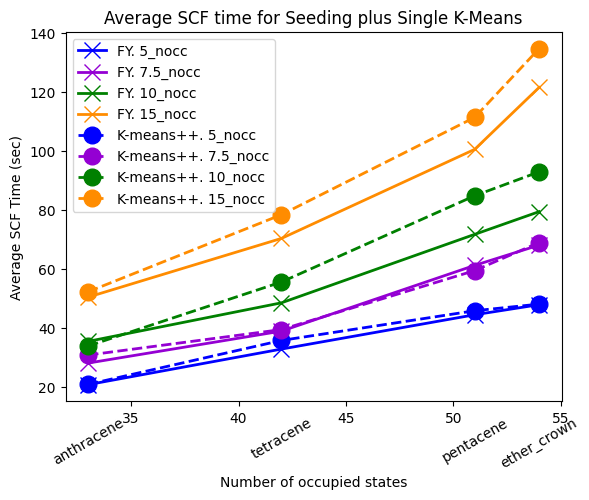

In [9]:
""" 
Average SCF timing comparison 
Noting that k-means will only be run for one iteration
"""
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Occupations
nocc = {'anthracene': 33, 'tetracene': 42, 'pentacene': 51, 'ether_crown': 54}

# x-axis
occupied = [occ for occ in nocc.values()] 

# Plot settings
settings = {'5_nocc':   {'color': 'blue',       'linewidth': 2, 'markersize': 12},
            '7.5_nocc': {'color': 'darkviolet', 'linewidth': 2, 'markersize': 12}, 
            '10_nocc':  {'color': 'green',      'linewidth': 2, 'markersize': 12},
            '15_nocc':  {'color': 'darkorange', 'linewidth': 2, 'markersize': 12}
          }

# Average SCF times when the centroids are seeded with Fisher-Yates
for label, data in isdf_scf_fy.items():
    plt.plot(occupied, data, 'x-', label=f"FY. {label}", **settings[label])

# Average SCF times when the centroids are seeded with K-means++
for label, data in isdf_scf_kmeanspp.items():
    plt.plot(occupied, data, 'o--', label=f"K-means++. {label}", **settings[label])

plt.xlabel("Number of occupied states")
plt.ylabel("Average SCF Time (sec)")
plt.legend()
plt.title("Average SCF time for Seeding plus Single K-Means")

# Add molecule names as minor ticks at the desired x positions
ax = plt.gca()
ax.xaxis.set_minor_locator(mticker.FixedLocator(list(nocc.values())))
ax.xaxis.set_minor_formatter(mticker.FixedFormatter(list(nocc.keys())))
ax.tick_params(axis='x', which='minor', length=0, pad=10, labelrotation=30)

plt.show()


In [13]:
"""Parse exchange energies computed with each method
"""
import copy

from isdfbenchmarks.parser import static


# Converged exact exchange energies, per molecule
ref_root = Path("/home/bucchera/exchange_calcs/ace_references")
ref_exx = {}
for molecule in molecules:
    ref_exx[molecule] = static.info_file(ref_root / molecule)['Energy']['Exchange']
    
# ISDF exact exchange energies seeded with FY
isdf_exx_fy = {}
for molecule in molecules:
    # Energies as a function of the number of ISDF vectors (== c * Nocc)
    energies = np.empty(shape=len(isdf_subdirs))
    for i, subdir in enumerate(isdf_subdirs):
        energies[i] = static.info_file(isdf_root / subdir / molecule)['Energy']['Exchange']
    isdf_exx_fy[molecule] = copy.deepcopy(energies)

# ISDF exact exchange energies seeded with K-means++
isdf_exx_kmeanspp = {}
for molecule in molecules:
    # Energies as a function of the number of ISDF vectors (== c * Nocc)
    energies = np.empty(shape=len(isdf_subdirs))
    for i, subdir in enumerate(isdf_subdirs):
        energies[i] = static.info_file(kmeanspp_isdf_root / subdir / molecule)['Energy']['Exchange']
    isdf_exx_kmeanspp[molecule] = copy.deepcopy(energies)

# ISDF exact exchange energies seeded with FY, running k-means for all SCF iterations
isdf_exx_fy_itrs = {}
for molecule in molecules:
    # Energies as a function of the number of ISDF vectors (== c * Nocc)
    energies = np.empty(shape=len(isdf_subdirs))
    for i, subdir in enumerate(isdf_subdirs):
        energies[i] = static.info_file(Path("/home/bucchera/exchange_calcs/fy_all_itrs") / subdir / molecule)['Energy']['Exchange']
    isdf_exx_fy_itrs[molecule] = copy.deepcopy(energies)

# ISDF exact exchange energies seeded with k, running k-means for all SCF iterations
# kmeanspp_all_itrs
# Prior code: Path("/home/bucchera/exchange_calcs/kmeanspp_nisdf_scaling_allsteps")
isdf_exx_kpp_itrs = {}
for molecule in molecules:
    # Energies as a function of the number of ISDF vectors (== c * Nocc)
    energies = np.empty(shape=len(isdf_subdirs))
    for i, subdir in enumerate(isdf_subdirs):
        energies[i] = static.info_file(
            Path("/home/bucchera/exchange_calcs/kmeanspp_all_itrs") / subdir / molecule)['Energy']['Exchange']
    isdf_exx_kpp_itrs[molecule] = copy.deepcopy(energies)    
    

[-5.08199629 -5.08704799 -5.08737224 -5.08739746]
[-6.48519206 -6.4932382  -6.49413133 -6.49420722]
[-7.87822953 -7.8922156  -7.89343559 -7.89364048]
[-9.33890428 -9.34737733 -9.34786012 -9.34787586]


In [18]:
"""Plot function for the error as a function of ISDF vector basis size
"""
import numpy as np

# Pre-factors to get total number of ISDF vectors
prefactors = [5.0, 7.5, 10.0, 15.0]
n_atoms = {"anthracene": 24.0, "tetracene": 30.0, "pentacene": 36.0, "ether_crown": 42.0}


def plot_error_line_plot(ref_exx, exx_fy, exx_kmeanspp):
    # Plot settings
    settings = {'anthracene':   {'color': 'blue',   'linewidth': 2, 'markersize': 8},
                'tetracene':    {'color': 'orange', 'linewidth': 2, 'markersize': 8}, 
                'pentacene':    {'color': 'green',  'linewidth': 2, 'markersize': 8},
                'ether_crown':  {'color': 'red',    'linewidth': 2, 'markersize': 8}
              }
        
    for molecule in molecules:
        exx_error = ( np.abs(exx_fy[molecule] - ref_exx[molecule])) / n_atoms[molecule]
        plt.plot(prefactors, exx_error, 'x-', label=molecule, **settings[molecule])
    
    settings = {'anthracene':   {'color': 'blue',   'linewidth': 2, 'markersize': 8, 'markerfacecolor':'none', 'markeredgewidth': 1.5},
                'tetracene':    {'color': 'orange', 'linewidth': 2, 'markersize': 8, 'markerfacecolor':'none', 'markeredgewidth': 1.5}, 
                'pentacene':    {'color': 'green',  'linewidth': 2, 'markersize': 8, 'markerfacecolor':'none', 'markeredgewidth': 1.5},
                'ether_crown':  {'color': 'red',    'linewidth': 2, 'markersize': 8, 'markerfacecolor':'none', 'markeredgewidth': 1.5}
              }
    
    for molecule in molecules:
        exx_error = np.abs(exx_kmeanspp[molecule] - ref_exx[molecule]) / n_atoms[molecule]
        plt.plot(prefactors, exx_error, 'o--', label=molecule,  **settings[molecule])
    
    plt.xlabel(r"ISDF Basis Size ($c N_{occ}$)")
    plt.ylabel("Error in Exact Exchange Energy (Ha / Atom)")
    plt.yscale('log')
    xmin, xmax = plt.xlim() 
    plt.hlines(1.e-6, xmin, xmax, colors="black", linestyles='dashed')
    plt.xlim(xmin, xmax)
    plt.legend()
        

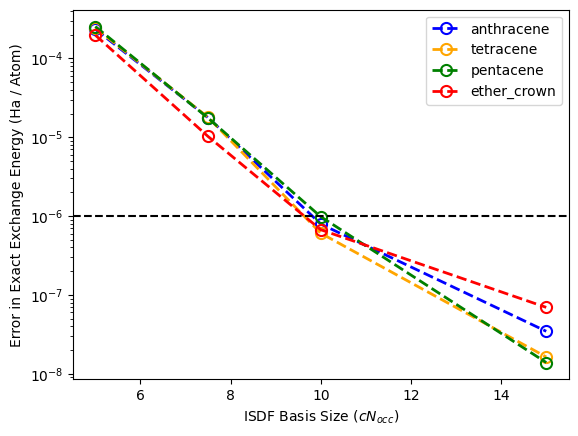

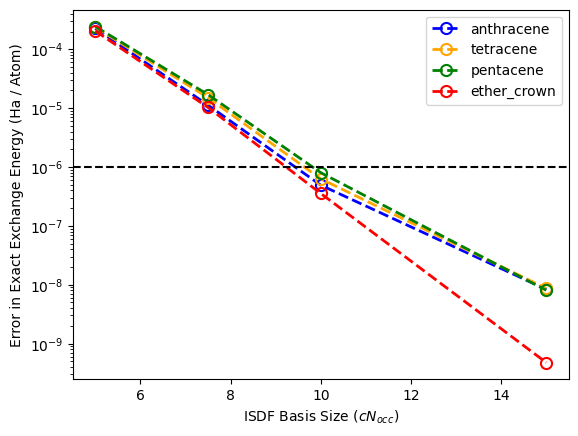

In [19]:
""" Plot the error in exact exchange energy as a function of ISDF vector basis size
"""

# For weighted kmeans on the first SCF iteration
plot_error_line_plot(ref_exx, isdf_exx_fy, isdf_exx_kmeanspp)
plt.show()

# For weighted kmeans on all SCF iterations
plot_error_line_plot(ref_exx, isdf_exx_fy_itrs, isdf_exx_kpp_itrs)
plt.show()


In [14]:
for molecule in molecules:
    print(molecule)
    fy_exx_error = (isdf_exx_fy[molecule] - ref_exx[molecule]) / n_atoms[molecule]
    kmeanspp_exx_error = (isdf_exx_kmeanspp[molecule] - ref_exx[molecule]) / n_atoms[molecule]
    print('Fisher-Yates | K-means++ | Diff')
    for i, pf in enumerate(prefactors):
        print(fy_exx_error[i], kmeanspp_exx_error[i], fy_exx_error[i] - np.abs(kmeanspp_exx_error[i]))
    print()

anthracene
Fisher-Yates | K-means++ | Diff
0.00026661458333332444 0.00023431500000000346 3.2299583333320975e-05
2.099416666667686e-05 1.77587500000224e-05 3.235416666654462e-06
2.070416666666297e-06 7.924999999945707e-07 1.2779166666717265e-06
2.916666685948144e-09 3.458333334519873e-08 -3.166666665925059e-08

tetracene
Fisher-Yates | K-means++ | Diff
0.00042292200000000336 0.0002437700000000061 0.00017915199999999726
4.703533333335249e-05 1.7872333333338966e-05 2.9163000000013524e-05
5.7156666666872505e-06 6.063333333491035e-07 5.109333333338147e-06
1.2900000001536682e-07 -1.6333333322885815e-08 1.12666666692481e-07

pentacene
Fisher-Yates | K-means++ | Diff
0.0005464852777777739 0.0002537216666666817 0.00029276361111109215
6.962166666666135e-05 1.7527222222233104e-05 5.209444444442824e-05
9.245833333344007e-06 9.824999999994176e-07 8.263333333344588e-06
1.5694444445281243e-07 1.388888890316606e-08 1.4305555554964638e-07

ether_crown
Fisher-Yates | K-means++ | Diff
0.00025381928571428

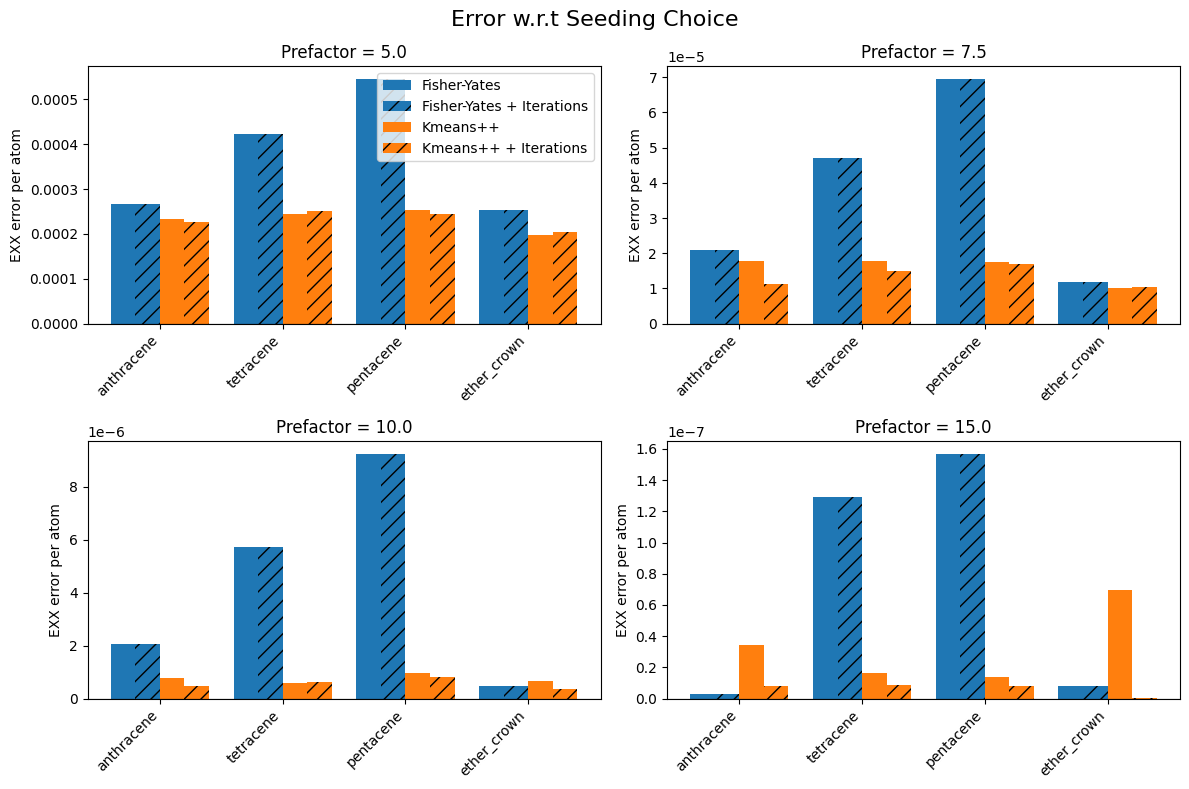

In [21]:
""" Error Running Seeding Followed by Weighted K-Means Once (first SCF step)
"""
import numpy as np
import matplotlib.pyplot as plt

prefactors = [5.0, 7.5, 10.0, 15.0]
n_atoms = {"anthracene": 24.0, "tetracene": 30.0,
           "pentacene": 36.0, "ether_crown": 42.0}
molecules = list(n_atoms.keys())
isdf_subdirs = ['5_nocc', '7.5_nocc', '10_nocc', '15_nocc']



settings = {
    'anthracene':  {'color': 'blue',   'linewidth': 2, 'markersize': 8},
    'tetracene':   {'color': 'orange', 'linewidth': 2, 'markersize': 8},
    'pentacene':   {'color': 'green',  'linewidth': 2, 'markersize': 8},
    'ether_crown': {'color': 'red',    'linewidth': 2, 'markersize': 8},
}

methods = {
    "fy": {
        "label": "Fisher-Yates",
        "color": "C0",
        "hatch": ''
    },
    "fy_itrs": {
        "label": "Fisher-Yates + Iterations",
        "color": "C0",
        "hatch": '//'
    },
    "kpp": {
        "label": "Kmeans++",
        "color": "C1",
        "hatch": ''
    },
    "kpp_itrs": {
        "label": "Kmeans++ + Iterations",
        "color": "C1",
        "hatch": '//'
    }
}

errors = {key: {} for key in methods}

for mol in molecules:
    errors["fy"][mol] = (np.array(isdf_exx_fy[mol]) - ref_exx[mol]) / n_atoms[mol]
    errors["fy_itrs"][mol] = (np.array(isdf_exx_fy_itrs[mol]) - ref_exx[mol]) / n_atoms[mol]
    errors["kpp"][mol] = np.abs(np.array(isdf_exx_kmeanspp[mol]) - ref_exx[mol]) / n_atoms[mol]
    errors["kpp_itrs"][mol] = np.abs(np.array(isdf_exx_kpp_itrs[mol]) - ref_exx[mol]) / n_atoms[mol]


n_mols = len(molecules)
x = np.arange(n_mols)  # positions for the molecule groups
method_keys = list(methods.keys())
n_methods = len(method_keys)
bar_width = 0.8 / n_methods  # total width ~0.8, split among methods

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

    # Reference error is zero by definition
for i_pref, (ax, pref) in enumerate(zip(axes, prefactors)):
    for i_meth, mkey in enumerate(method_keys):
        offset = (i_meth - (n_methods - 1) / 2) * bar_width
        values = [errors[mkey][mol][i_pref] for mol in molecules]

        ax.bar(
            x + offset,
            values,
            width=bar_width,
            label=methods[mkey]["label"] if i_pref == 0 else None,  # legend only once
            color=methods[mkey]["color"],
            hatch=methods[mkey]["hatch"]
        )

    ax.set_title(f"Prefactor = {pref}")
    ax.set_xticks(x)
    ax.set_xticklabels(molecules, rotation=45, ha="right")
    ax.axhline(0.0, color="black", linewidth=0.8)
    ax.set_ylabel("EXX error per atom")

# Put one legend outside or on the first axis
axes[0].legend(loc="best")

fig.suptitle("Error w.r.t Seeding Choice", fontsize=16)

fig.tight_layout()
plt.show()


For FY, should confirm there is a small difference for 1 vs all SCF iterations (relative to choice of seeding)

Note, some weird problem with ether crown, where two occupied states in 5-nocc and 7.5-nocc are not converging (even though higher states are) causing the SCF to run to the max